In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [7]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
session = Session(engine)

In [9]:
for row in session.query(Measurement.id, Measurement.tobs).limit(5).all():
    print(row)

(1, 65.0)
(2, 63.0)
(3, 74.0)
(4, 76.0)
(5, 73.0)


In [10]:
for row in session.query(Station.id, Station.latitude, Station.longitude, Station.elevation).limit(5).all():
    print(row)

(1, 21.2716, -157.8168, 3.0)
(2, 21.4234, -157.8015, 14.6)
(3, 21.5213, -157.8374, 7.0)
(4, 21.3934, -157.9751, 11.9)
(5, 21.4992, -158.0111, 306.6)


In [20]:
recent_date_query = session.execute("SELECT MAX(date) FROM measurement").scalar()
recent_date = dt.datetime.strptime(recent_date_query, "%Y-%m-%d").date()
print(recent_date)

2017-08-23


In [12]:
for_year_ago = dt.datetime.combine(recent_date, dt.datetime.min.time())
year_ago = recent_date - relativedelta(months = 12)
print(year_ago)

2016-08-23


In [13]:
data_for_year = session.query(Measurement.date, Measurement.prcp).\
filter(and_(Measurement.date >= year_ago, Measurement.date <= recent_date)).\
order_by(Measurement.date).all()


In [14]:
dates = [row.date for row in data_for_year]
prcp = [row.prcp for row in data_for_year]

In [15]:
past_year_df = pd.DataFrame({
    "Date": dates,
    "Precipitation": prcp})
past_year_nonull = past_year_df.dropna()
past_year_nonull

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


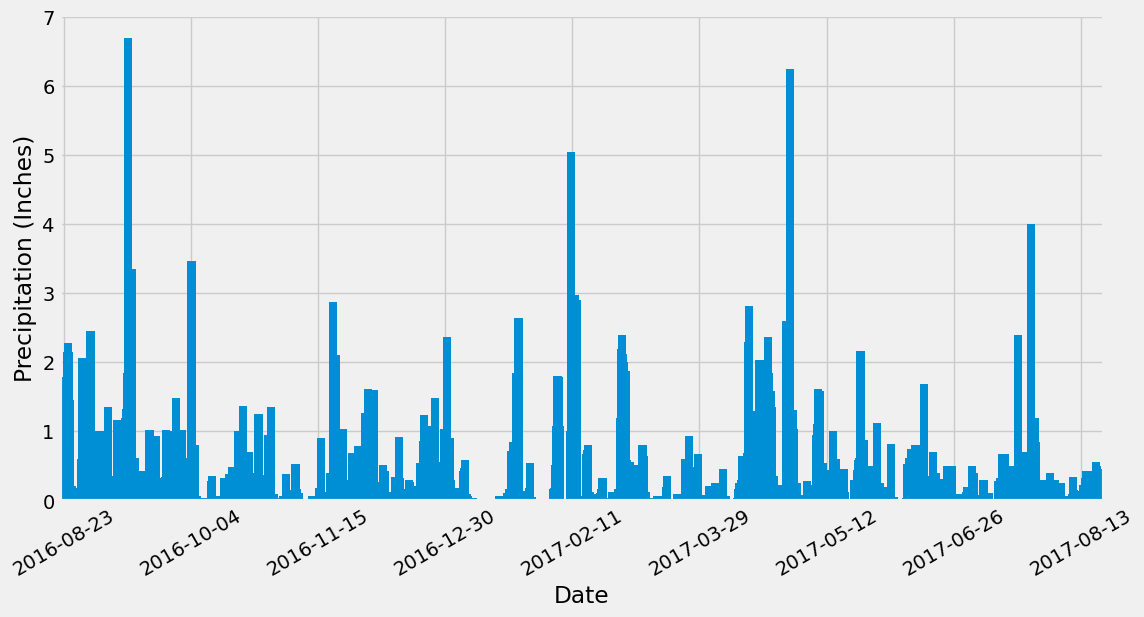

<Figure size 640x480 with 0 Axes>

In [16]:
x_axis = past_year_nonull["Date"]
y_axis = past_year_nonull["Precipitation"]

bar_chart_df = pd.DataFrame({'Date': x_axis, 'Precipitation': y_axis})
ax = bar_chart_df.plot(kind='bar', x='Date', y='Precipitation', legend=False, width = 16, figsize=(12,6))
ax.set_xticks(np.arange(0, len(bar_chart_df['Date']), 248))
ax.set_xticklabels(bar_chart_df['Date'][::248], rotation=30)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.show()
plt.tight_layout()

In [17]:
past_year_nonull.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
number_of_stations = session.query(Station.id).count()
number_of_stations

9

In [19]:
station_busyness = session.query(Measurement.station, func.count().label('count')) \
.group_by(Measurement.station) \
.order_by(func.count().desc()) \
.all()
station_busyness
# USC00519281 is the most active station, with 2772 observations.

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
most_active = session.query(Measurement.station, func.count().label('count')) \
.group_by(Measurement.station) \
.order_by(func.count().desc()) \
.first()
most_active

('USC00519281', 2772)

In [21]:
busiest_station = most_active[0]
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == busiest_station).scalar()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == busiest_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == busiest_station).scalar()
print(max_temp, min_temp, avg_temp)

85.0 54.0 71.66378066378067


In [22]:
past_year_busiest_station = session.query(Measurement.tobs).filter(and_(Measurement.date >= year_ago, Measurement.date <= recent_date, Measurement.station == busiest_station)).all()

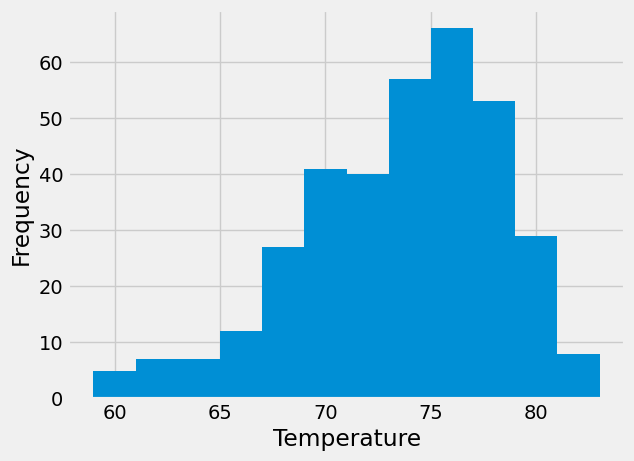

In [23]:
array_of_pybs = np.array([past_year_busiest_station])
flattened_array = array_of_pybs.ravel()
plt.hist(flattened_array, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [24]:
session.close()